### Autores

- Bruno Leandro Pereira
Ra 791067

- Carlos Eduardo Fontaneli
RA 769949 

- Ivan Duarte Calvo 
Ra 790739


### Importação das Bibliotecas Externas

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import Colormap 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

### Descrição do Conjunto de Dados

O dataset selecionado possui como objetivo a classificação de qual o melhor remédio para uma dada doença baseado nas característcas dos pacientes. Dessa forma, pode-se interpretar o contexto do mesmo como uma conjunto de dados de pacientes que sofreram de uma determinada doença e responderam positivamente a um determinado remédio. Logo, com base em características desses pacientes e suas respostas aos remédios observados, o objetivo é treinar um modelo que seja capaz de prescrever o tipo de remédio mais indicado para futuros pacientes com a mesma doença.

O conjunto possui como atributos a idade, sexo, pressão sanguínea, nível de colesterol e a relação sódio/potássio no sangue do paciente em questão. Por fim, a classe alvo é o remédio que tal paciente teve a melhor resposta dentre as 5 opções disponíveis. Uma característica interessante do dataset escolhido é a variedade entre os tipos de atributos presentes:
    
- Idade: Atributo Numérico/Quantitativo
- Sexo, Pressão Sanguínea e Cloresterol: Atributos Nominais
- Sódio/Potássio: Atributo Contínuo

### Leitura dos dados

Abaixo é feita a leitura dos dados em formato de `Dataframe`.

In [49]:
drug_dataset = pd.read_csv("drug200.csv")
drug_dataset.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


### Análise Exploratória dos Dados

Nessa etapa, foram elaborados gráficos e figuras que permitem uma melhor comprensão sobre a distribuição dos dados dentro do conjunto. Além disso, buscou-se analisar possíveis desbalanceamentos entre classes e/ou outliers.

Os remédios Y e X são os mais utilizados, enquanto A, B e C tem uma utilização bem mais reduzida

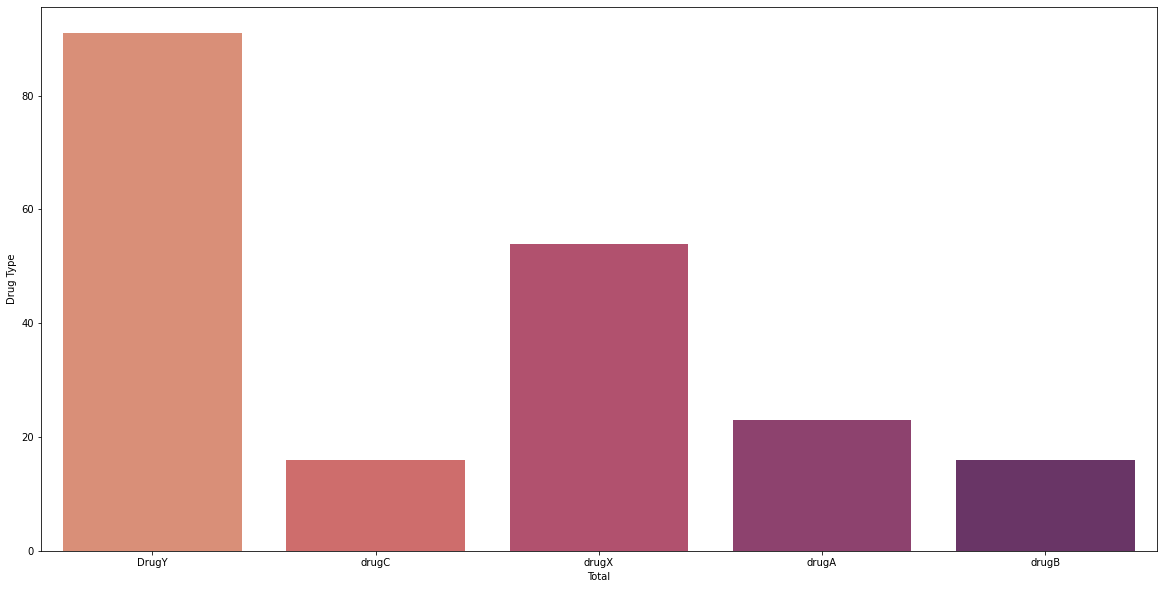

In [50]:
plt.figure(figsize= [20,10])
sns.countplot(x="Drug", data=drug_dataset, palette="flare")
plt.ylabel('Drug Type')
_ = plt.xlabel('Total')

Já o nível de cloresterol no sangue dos pacientes possui uma distribuição mais equilibrada, sendo a quantidade de pacientes com alto nível de cloresterol um pouco maior que a de pacientes com um nível definido como normal.

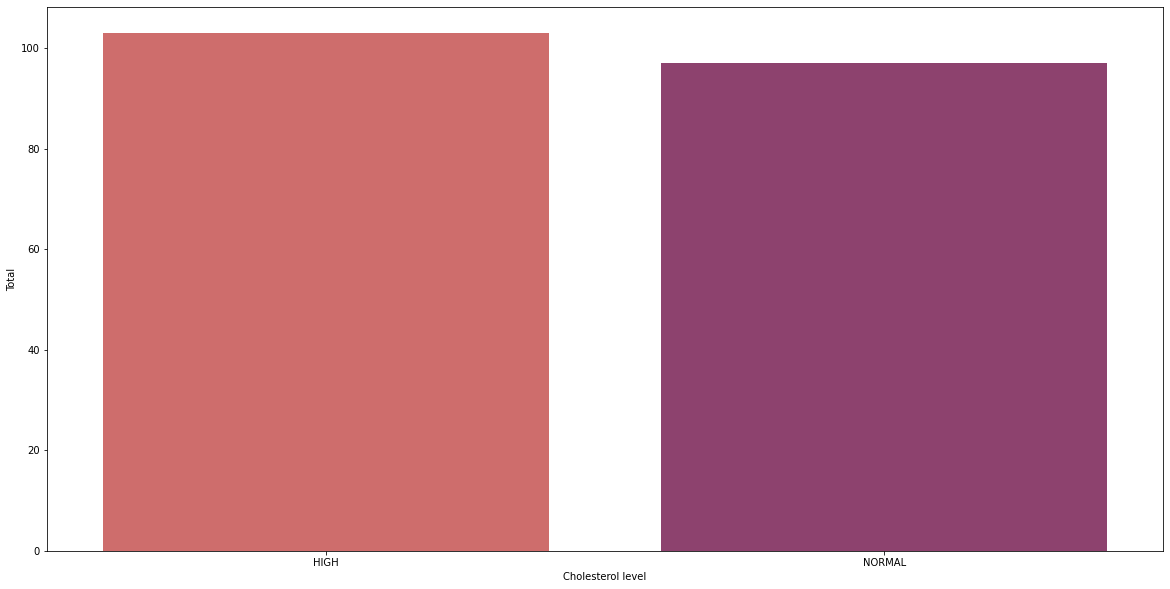

In [51]:
plt.figure(figsize= [20,10])
sns.countplot(x="Cholesterol", data=drug_dataset, palette="flare")
plt.xlabel('Cholesterol level')
_ = plt.ylabel('Total')

O sexo dos pacientes também é bem distribuído dentro do conjunto, com uma pequena vantagem no número de pacientes do sexo masculino.

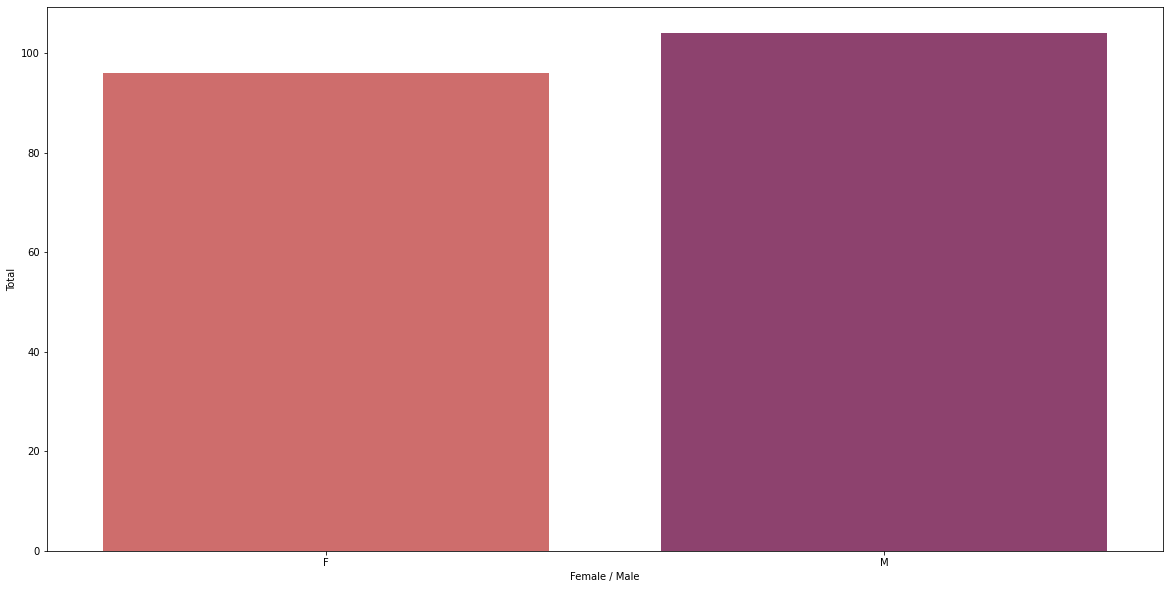

In [52]:
plt.figure(figsize= [20,10])
sns.countplot(x="Sex", data=drug_dataset, palette="flare")
plt.xlabel('Female / Male')
_ = plt.ylabel('Total')

Já na Pressão Sanguínea, pode-se observar que a parte dos pacientes que está com um nível normal é menor, sendo os pacientes com alto nível a maior distribuição, seguida pelos pacientes com baixo nível.

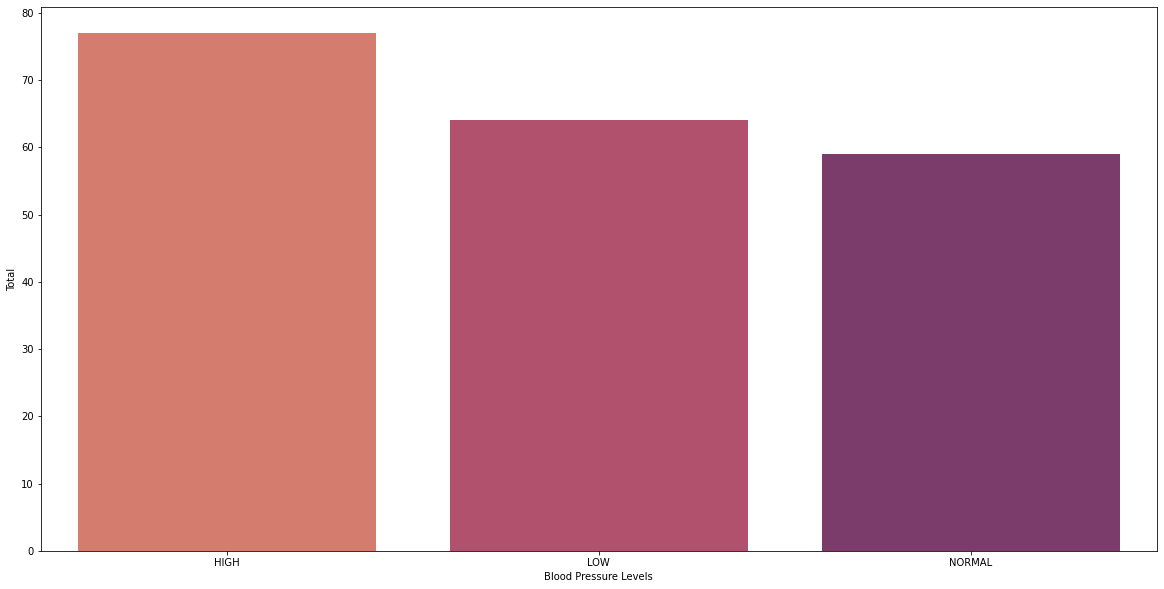

In [53]:
plt.figure(figsize= [20,10])
sns.countplot(x="BP", data=drug_dataset, palette="flare")
plt.xlabel('Blood Pressure Levels')
_ = plt.ylabel('Total')

Nos próximos gráficos podemos perceber a distribuição dos pacientes em relação à proporção Sódio/Potássio e também em relação à idade.
No caso da Relação Sódio/Potássio, há uma predominância nos níveis próximos de 10, o que pode-se ser um resultado esperado para pessoas com alguma irregularidade dado que níveis recomendados de proporção são de 1:3(ou seja, três vezes mais potássio) no sangue. 

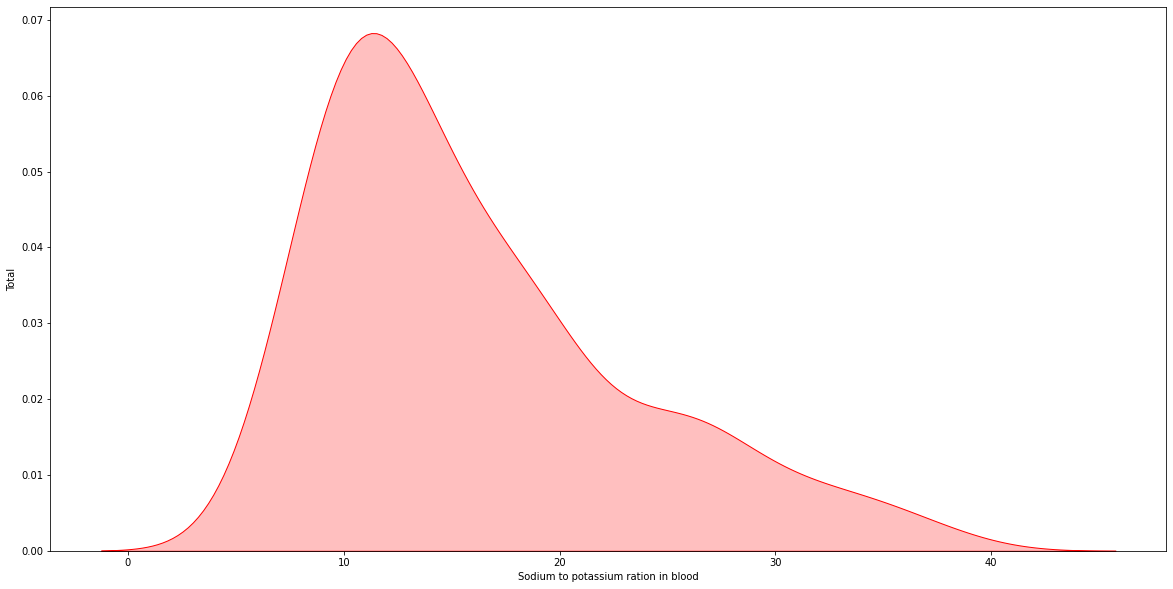

In [54]:
plt.figure(figsize= [20,10])
sns.kdeplot(drug_dataset["Na_to_K"], color = 'red', fill = True)
plt.xlabel('Sodium to potassium ration in blood')
_ = plt.ylabel('Total')

E em relação à Idade, vemos uma maioria em torno da faixa dos 40 anos a 60 anos, o que mostra-se como a região central dos valores observados. Ademais, pode-se observar que a distribuição aparenta ter um comportamento de distribuição normal o que é compreensível por se tratar de um atributo relativo a idade dos pacientes algo que mede um fenômeno natural, logo a possível relação com a distribuição normal.

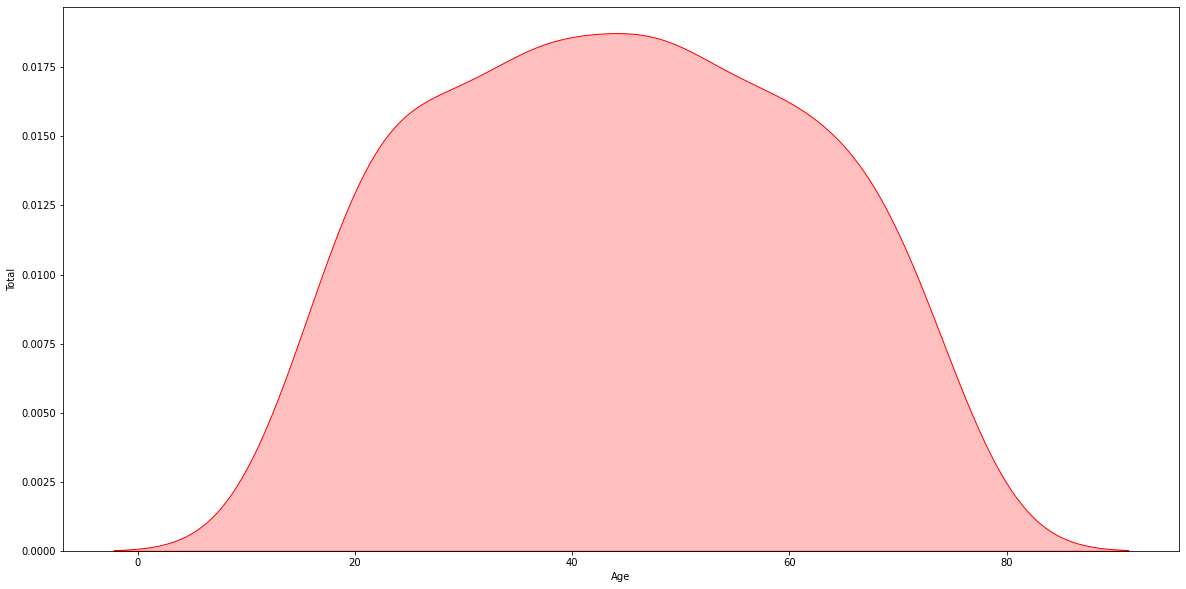

In [55]:
plt.figure(figsize= [20,10])
sns.kdeplot(drug_dataset["Age"], color = 'red', fill = True)
plt.xlabel('Age')
_ = plt.ylabel('Total')

Por fim, buscou-se analisar possíveis `outliers` para os dados contínuos do conjunto de dados selecionados, pois eles podem influenciar no resultado do modelo. Dessa forma, traçou-se os `boxplots` dos atributos idade e proporção sódio para potássio no sangue.

É possível notar a ausência de outliers no atributo idade, o que já era esperado dado que sua distribuição era bastante concentrada em torno da média. Por outro lado, na proporção sódio para potássio no sangue é possível perceber alguns indíviduos com níveis acima do 30%, o que foge do padrão demonstrado pelos demais indivíduos podendo caracterizar `outliers`.

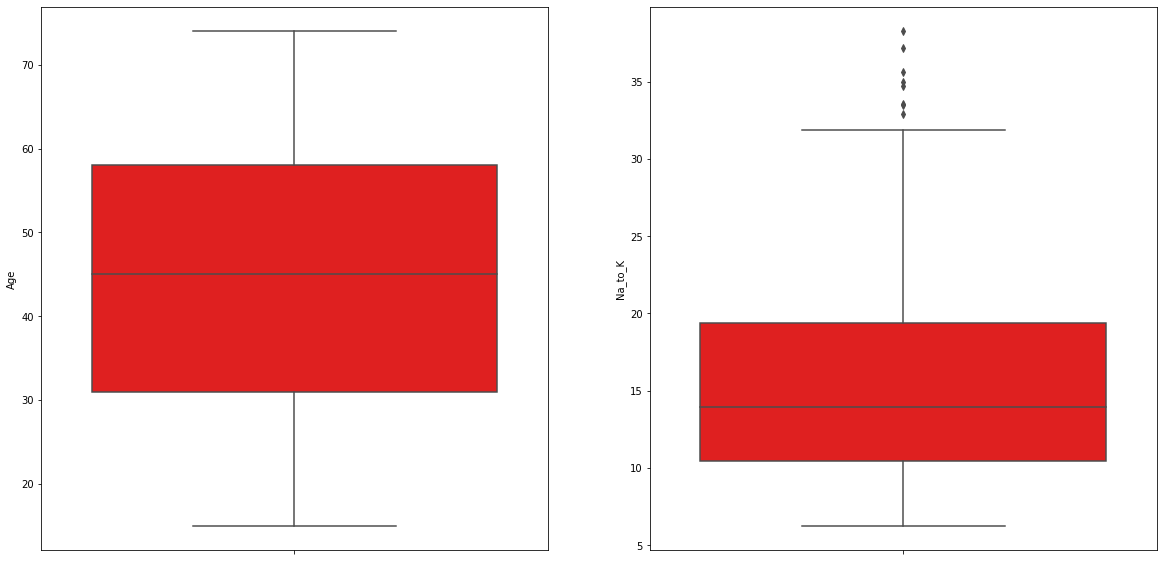

In [56]:
plt.figure(figsize= [20,10])
plt.title('Boxplot das variáveis contínuas')
plt.subplot(1, 2, 1)
sns.boxplot(y=drug_dataset["Age"], color = 'red')
plt.subplot(1, 2, 2)
_ = sns.boxplot(y=drug_dataset["Na_to_K"], color = 'red')

## Metodologia de implementação adotada

Como foi escolhido aplicar e avaliar três tipos de modelos de aprendizado(`DecisionTree`, `KNearestNeighbor` e `GaussianNaiveBayes`), cada um com necessidades e parâmetros próprios, optou-se por sistemar as etapas de pré-processamento dos dados, treinamento, teste e avaliação dos modelos, dessa forma tais etapas foram declaradas como funções. Dessarte, o código torna-se mais limpo, mais suscetível a manutenção e mais legível.

### Pré-processamento universal dos dados

Apesar das particularidades de cada modelo, para o pré-processamento eles compartilham certas necessidades iguais. Pensando nisto, criou-se uma função que aplica um pré-processamento universal nos dados, ou seja, que prepara os dados de uma forma que todos os modelos precisam.
 
Assim sendo, de começo, separou-se os dados entre atributos e classe alvo. Na sequência, transformou-se com a função `LabelEncoder()` os atributos nominais em valores entre [0, número_de_classes - 1], dessa forma o que era nominal fica como discreto, tal processo foi feito na classe alvo também. Ademais, separou-se se os dados entre o que é treino e o que é teste, seguindo uma proporção de 70% dos dados para treino e 30% para teste.

Por fim, como foram escolhidos os algoritmos `KNearestNeighbor`(que trabalha com cálculo de distância) e `GaussianNaiveBayes`(que trata os atributos como uma extração de uma distribuição gaussiana simples) aplica-se uma normalização nos dados com a função `StandarScaler`, pois é vantajoso ter atributos contínuos para o cálculo de distância Euclidiana e para trabalhar com distribuição gaussiana dos atributos.

In [57]:
def pre_process(dataset, std_scaler = False):
  X = dataset.drop('Drug', axis=1)
  y = dataset['Drug']

  le = LabelEncoder()
  nominal_classes = ['Sex', 'BP', 'Cholesterol']
  
  for nominal_class in nominal_classes:
    X[nominal_class] = le.fit_transform( X[nominal_class])
  
  y = le.fit_transform(y)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  
  if std_scaler:
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)
    
  return X_train, X_test, y_train, y_test

### Pré-processamento adicional

Um segundo tipo de pré-processamento utilizado foi a remoção dos outliers e balanceamento das classes alvo com repetição de dados de classes com baixa recorrência no conjunto de dados. No entanto, esse método foi aplicado com a intenção de ser um pré-processamento adicional, assim pode-se testar os algoritmos com e sem o seu uso e avaliar se esse passo foi vantajoso ou não.

In [58]:
def additional_pre_process(dataset, drop_outliers = False, balance_target = False):  
  if drop_outliers:
    dataset = dataset.drop(dataset[dataset['Na_to_K'] > 32].index)
  
  if balance_target: 
    dataset_a = dataset[dataset['Drug'] == 'drugA']
    dataset_b = dataset[dataset['Drug'] == 'drugB']
    dataset_c = dataset[dataset['Drug'] == 'drugC']
    dataset_x = dataset[dataset['Drug'] == 'drugX']

    dataset = pd.concat([dataset, dataset_a, dataset_a, dataset_a])
    dataset = pd.concat([dataset, dataset_b, dataset_b, dataset_b, dataset_b])
    dataset = pd.concat([dataset, dataset_c, dataset_c, dataset_c, dataset_c])
    dataset = pd.concat([dataset, dataset_x])
    
  return dataset

### Métricas e matriz de confusão

Como métricas de avaliação usou-se a função `classification_report`, sendo seu retorno composto pelas seguinte métricas: `precision`, `recall`, `f1-score` e `accuracy`.
Além disso, exibiu-se para cada modelo sua matriz de confusão.

In [59]:
def metrics_cf(y_test, y_pred, metrics_dict):
  metrics = classification_report(y_test, y_pred, output_dict=metrics_dict)

  c_matrix = confusion_matrix(y_test, y_pred)

  return metrics, c_matrix

In [60]:
# Implementação da plotagem automática de matrizes de confusão
def plot_cf(c_matrix, classifier):
  
  class_names = ['DrugY', 'DrugA', 'DrugB', 'DrugC', 'DrugX']
  fig, ax = plot_confusion_matrix(conf_mat=c_matrix,
                                  show_absolute=True,
                                  colorbar=True, 
                                  class_names=class_names, 
                                  figsize=(10, 10));
  
  plt.title('Confusion Matrix - %s ' % classifier)
  _ = plt.savefig('confusion_matrix_%s.png' % classifier, dpi=fig.dpi);
  
  plt.show();

### Generização do treino e teste dos modelos

Como foi citado a cima, o treino, teste e avaliação dos modelos foi feita de forma automatizado, logo abaixo segue a implementação responsável por essas etapas.

Tal função recebe o conjunto de dados, o modelo a ser utilizado, se será aplicado pré-processamentos adicionais e a quantidade de vizinho para o `k-NN` caso o usuário queira alterar o padrão de 5. Dessa forma, ela aplica o pré-processamento adicional aos dados se assim for estipulado e depois ela irá preparar os dados treinar, executar e avaliar cada modelo conforme suas características.

Para o modelo de Árvore de Decisão a função aplica o pré-processamento universal sem a normalização, aplica o pré-processamento adicional se assim estipulado, depois treina e testa o algoritmos, avaliando seu resultados para ter como retorno da função o modelo, as métricas de avaliação e a matriz de confusão.

Para os modelos de K Vizinho Mais Próximo e Bayes Ingênuo a função aplica os mesmos passos aplicados para Árvores de Decisão com a adição da normalização dos dados no pré-processamento universal.

In [61]:
def train_test_classifier(dataset, dec_tree = False, gauss_nb = False, knn = False, drop_outliers = False, balance_target = False, n_neighbors=5, metrics_dict = False):
  
  # Aplicando pre-processamento adicional caso determinado
  dataset = additional_pre_process(dataset, drop_outliers, balance_target)
  
  if dec_tree:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset = dataset)
    
    
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix, = metrics_cf(y_test, y_pred, metrics_dict)
    
    return classifier, metrics, c_matrix
  
  elif gauss_nb:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset, std_scaler=True)
    
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix, = metrics_cf(y_test, y_pred, metrics_dict)
    
    return classifier, metrics, c_matrix
    
  elif knn:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset, std_scaler=True)
    
    classifier = KNeighborsClassifier(n_neighbors = n_neighbors)
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix = metrics_cf(y_test, y_pred, metrics_dict)
    
    return classifier, metrics, c_matrix

### Decision Tree

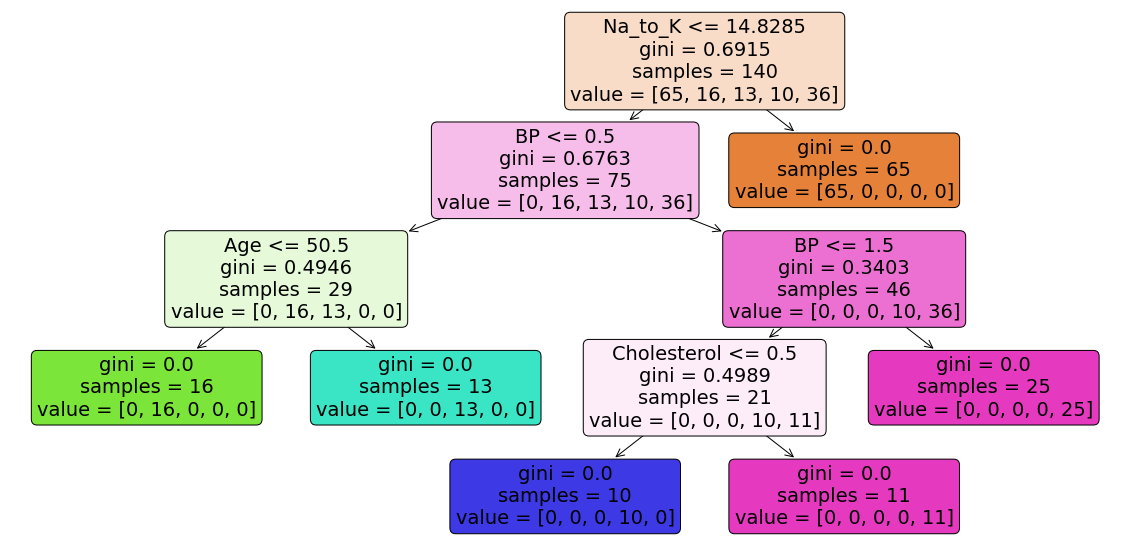

In [62]:
tree_classifier, tree_metrics, tree_c_matriz = train_test_classifier(dataset=drug_dataset, dec_tree = True)

# Plotando a arvores gerada
plt.figure(figsize = (20,10))
decision_tree = plot_tree(decision_tree=tree_classifier, 
                          feature_names = drug_dataset.columns, 
                          filled = True , 
                          precision = 4, 
                          rounded = True)

### Resultados Obtidos

Ao final dos testes, obtivemos uma acurácia de 100%, o que é bom para esses dados, entretanto, para classificação de novos dados pode ser um pro

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



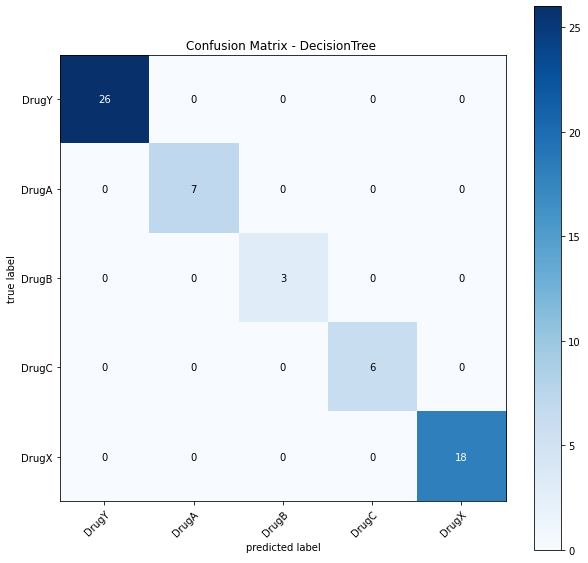

In [63]:
print(tree_metrics)
plot_cf(tree_c_matriz, classifier='DecisionTree')

### k-NN

Inicialmente, para a implementação do k-NN, foi estudada qual seria a melhor quantidade k de vizinhos para a utilização do algoritmo. Para isso, foram testadas em um laço, todas as quantidades ímpares entre 1 e 19 (1,3,5,...,19). Por fim, foi elaborado um gráfico que permite uma visualização melhor da performance do algoritmo de acordo com a quantidade k escolhida.
Também foi realizada a comparação da eficácia do algoritmo utilizando ou não o pré-processamento adicional dos dados com a remoção de *outliers* e o balanceamento das classes alvo.

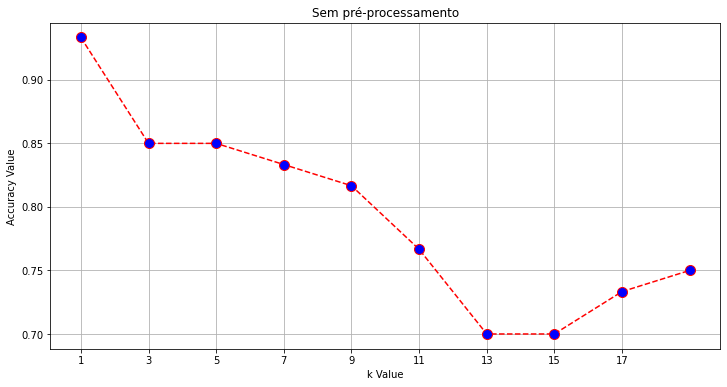

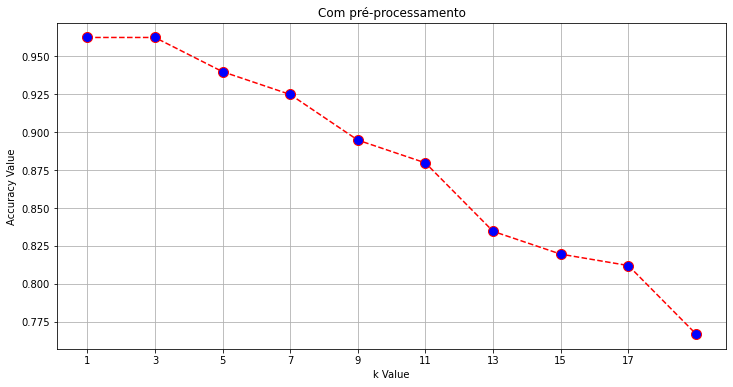

In [64]:
metricsList = list()
metricsListApp = list()

for i in range(1, 20, 2):
    knn_classifier, knn_metrics, knn_c_matriz = train_test_classifier(dataset=drug_dataset,  knn=True, n_neighbors=i, metrics_dict=True)
    knn_app_classifier, knn_app_metrics, knn_app_c_matriz = train_test_classifier(dataset=drug_dataset,  knn=True, n_neighbors=i, drop_outliers=True, balance_target=True, metrics_dict=True)
    metricsList.append(knn_metrics['accuracy'])
    metricsListApp.append(knn_app_metrics['accuracy'])

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20,2), metricsList, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Sem pré-processamento')
plt.xlabel('k Value')  
plt.ylabel('Accuracy Value') 
plt.grid(visible=True)
plt.xticks(np.arange(1, 19, step=2))

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20,2), metricsListApp, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Com pré-processamento')
plt.xlabel('k Value')  
plt.ylabel('Accuracy Value') 
plt.grid(visible=True)
_ = plt.xticks(np.arange(1, 19, step=2))

Após a análise dos resultados, a quantidade de vizinhos escolhida foi `k=5`, pois apresentou um valor interessante de acurácia ao mesmo tempo que não ouve um *overfitting*. Como o k-NN é um algoritmo relativamente simples que calcula a distância entre os dados, é compreensível o grande implemento de performance ao se balancear as classes e remover os *outliers*. Portanto, é nítido o aumento do valor da acurácia obtido ao se utilizar o pré-processamento adicional dos dados e nessa modalidade, a quantidade ideal de vizinhos para um funcionamento satisfatório do algoritmo seria de `k=9`.

In [65]:
knn_classifier, knn_metrics, knn_c_matriz = train_test_classifier(dataset=drug_dataset, knn = True)
knn__app_classifier, knn_app_metrics, knn_app_c_matriz = train_test_classifier(dataset=drug_dataset, knn = True, n_neighbors=9, drop_outliers=True, balance_target=True)

### Resultados k-NN

Compreendendo o funcionamento do algoritmo, ao pré-processar os dados de maneira correta é possível esperar que para o *dataset* e o problema selecionados o algoritmo k-NN obtenha resultados consideravelmente satisfatórios em relação à precisão e acurácia. Há uma perceptível melhora na acurácia do algoritmo quando se compara o seu funcionamento em relação à utilização ou não da remoção dos *outliers* e do balanceamento das classes, o que corrobora com o comportamento esperado para o algoritmo, visto que a classificação é realizada com base apenas nos dados previamente inseridos na memória.

In [66]:
print('Sem Pré-processamento adicional')
print(knn_metrics, '\n')

print('Com Pré-processamento adicional')
print(knn_app_metrics, '\n')

Sem Pré-processamento adicional
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.88      1.00      0.93         7
           2       0.60      1.00      0.75         3
           3       1.00      0.50      0.67         6
           4       0.85      0.94      0.89        18

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.82        60
weighted avg       0.87      0.85      0.85        60
 

Com Pré-processamento adicional
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        25
           1       0.85      1.00      0.92        23
           2       0.89      0.96      0.93        26
           3       0.77      1.00      0.87        17
           4       0.95      0.86      0.90        42

    accuracy                           0.89       133
   macro avg       0.89      0.91      0.89       133
weighted av

Sem pré-processamento adicional


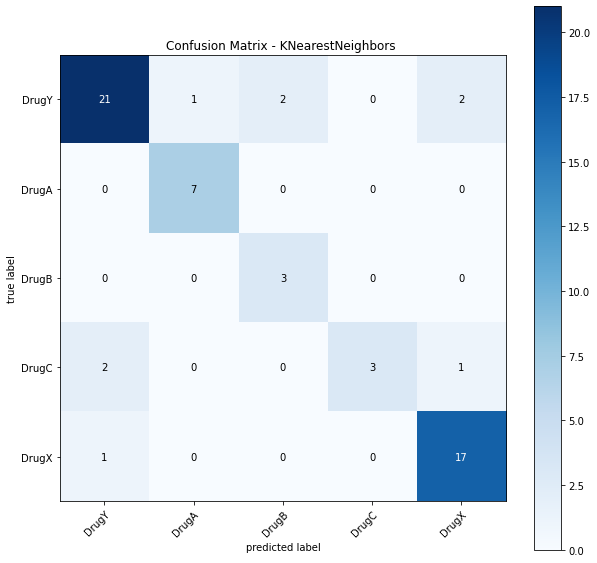

Com pré-processamento adicional


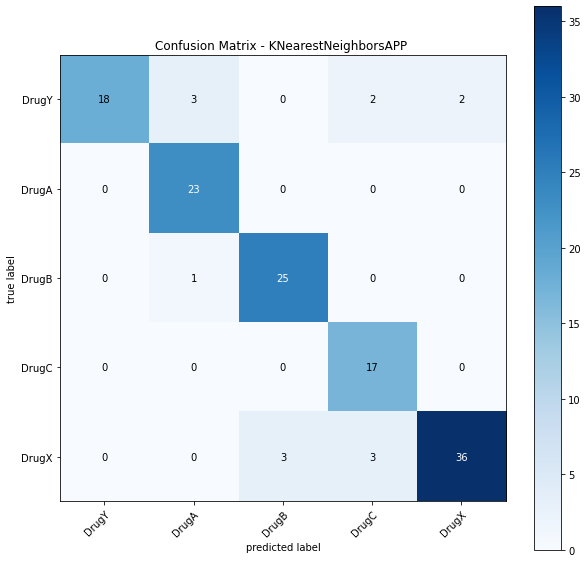

In [67]:
print('Sem pré-processamento adicional')
plot_cf(knn_c_matriz, classifier='KNearestNeighbors')

print('Com pré-processamento adicional')
plot_cf(knn_app_c_matriz, classifier='KNearestNeighborsAPP')

### Gaussian Naive Bayes

Tendo em vista que o conjunto de dados selecionado trata de fenômenos naturais relacionados a reação de corpos humanos para determinados remédios visando tratar uma doença, acreditou-se que poderia ser uma boa escolha assumir um modelo que trabalhasse com algum tipo de distribuição normal ou gaussiano, por isso a escolha do `Gaussian Naive Bayes`. Tal modelo foi apresentado durante aula e, trabalhando-se com atributos contínuos, assume que a distribuição dos dados se da seguindo o comportamento de uma distribuição gaussiana, podendo ter uma forte relação intrisica ao contexto do conjutno de dados escolhido.

In [68]:
# Executando o modelo sem o pré-processamento adicional
gauss_nb_classifier, gauss_nb_metrics, gauss_nb_c_matriz = train_test_classifier(dataset=drug_dataset, gauss_nb = True)

# Executando o modelo com o pré-processamento adicional
g_nb_app_classifier, g_nb_app_metrics, g_nb_app_c_matriz = train_test_classifier(dataset=drug_dataset, gauss_nb = True, drop_outliers=True, balance_target=True)

### Resultados e conclusões sobre o modelo Gaussian Naives Bayes

Analisando a matriz de confusão da execução do modelo sem o pré-processamento adicional, pode-se perceber que os erros acontecem na classe com a maior recorrência no conjunto de dados e as classificações estão atreladas as classes que possuem menos amostras. Tal comportamento parece ser condizente a natureza do modelo já que o mesmo é probabilístico, portanto a tendência é dos erros se acumularem na classe de maior recorrência. Para a segunda matriz, onde houve o pré-processamento adicional ao modelo, é possível perceber uma pequena diminuição proporcional nos erros relativos a classe com maior recorrência no conjunto de dados original, um comportamento também esperado dado que além da remoção de `outliers` houve um balanceamento nas classes menos recorrentes.

Gaussian Naives Bayes - Confusion Matrix


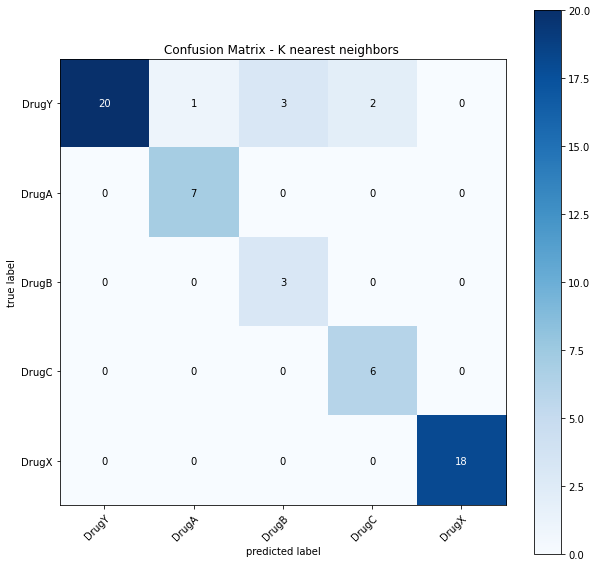

Gaussian Naives Bayes with additional pre-process - Confusion Matrix


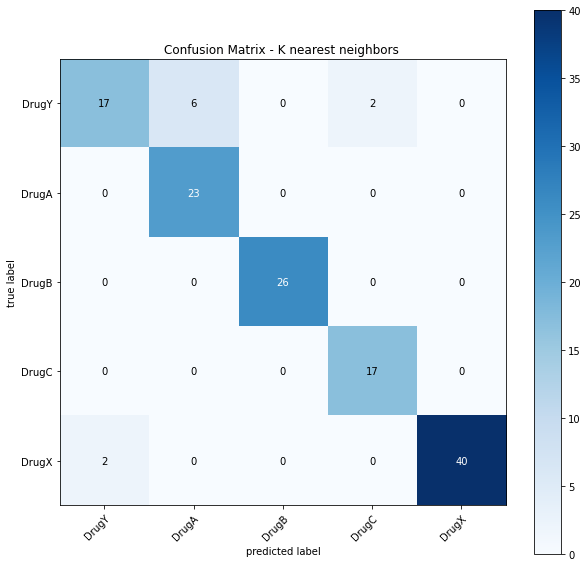

In [69]:
print('Gaussian Naives Bayes - Confusion Matrix')
plot_cf(gauss_nb_c_matriz, classifier='K nearest neighbors')

print('Gaussian Naives Bayes with additional pre-process - Confusion Matrix')
plot_cf(g_nb_app_c_matriz, classifier='K nearest neighbors')

Pode-se inferir que para o conjunto de dados sem o pré-processamento adicional houve penalização maior para a métrica de precisão, dado que tal métrica visa calcular a proporção de verdadeiros positivos acertados, como a maioria dos erros se encontra em classificações falsas positivas para a classe `DrugY`(mais recorrente) é de se esperar que a precisão acabe sendo menor que as outras métricas. Em contraposição, a métrica recall obteve o melhor resultado, pois como tal métrica é penalizada por classificações falso negativas e o modelo errou pouco nesse questio a métrica obteve um bom resultado.

Ao aplicar o pré-processamento adicional é possível notar uma melhora grande na precisão do modelo e melhoras na acurácia e f1-score, concordando com a análise da matriz de confusão. Por outro lado a métrica recall teve uma pequena diminuição, o que se observou na classificação de falso negativos na classe `DrugY`, tal comportamento pode estar relacionado ao balanceamento das classes como um todo causando uma perca de capacidade do modelo em classificar a classe mais recorrente.

Ambas as execuções apresentaram uma acurácia de pelo menos de 90% o que é um valor alto, podendo até caracterizar `overfitting`. Com tal resultado e levando em consideração o contexto dos dados, surge o debate em que o que é mais importante para o usuário final do modelo a capacidade de generalização ou a precisão do modelo. 

O modelo apresentou uma acurácia alta, podendo significar incapacidade de generalização, logo se chegar novos dados que não apresentem os mesmo comportamento dos dados de teste e treino o modelo pode errar significativamente. Por outro lado, como os dados tratam de questões físicas do corpo humano e reações deles a determinado remédio para doenças pode ser interessante um modelo bastante preciso, pois de forma geral o corpo humano não apresenta grandes variações de pessoa pra pessoa em relação a sintomas de doenças e eficácia de remédios pra uma mesma doença. Portanto, mostra-se essencial a consultoria de uma especialista na área de saúde para analisar tais questões. 


In [70]:
print('Gaussian Naives Bayes')
print(gauss_nb_metrics, '\n')

print('Gaussian Naives Bayes with additional pre-process')
print(g_nb_app_metrics, '\n')

Gaussian Naives Bayes
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        26
           1       0.88      1.00      0.93         7
           2       0.50      1.00      0.67         3
           3       0.75      1.00      0.86         6
           4       1.00      1.00      1.00        18

    accuracy                           0.90        60
   macro avg       0.82      0.95      0.87        60
weighted avg       0.94      0.90      0.90        60
 

Gaussian Naives Bayes with additional pre-process
              precision    recall  f1-score   support

           0       0.89      0.68      0.77        25
           1       0.79      1.00      0.88        23
           2       1.00      1.00      1.00        26
           3       0.89      1.00      0.94        17
           4       1.00      0.95      0.98        42

    accuracy                           0.92       133
   macro avg       0.92      0.93      0.92       133
wei

### Considerações Finais

O k-NN possui uma elevada capacidade de generalização, ao mesmo tempo em que pode obter também uma acurácia grande. Essa variação apresentada é devida a possibilidade de personalização na quantidade k de vizinhos utilizada para a realização dos cálculos da distância. Portanto, ele mostra-se um modelo bastante adaptativo, podendo atender a demanda de um algoritmo que seja bastante preciso para dados similares ao do conjunto atual e, atender a demanda de um modelo que tenha bastante capacidade de generalização.

O modelo de Gaussian Nayve Bayes se mostrou bastante preciso, obtendo uma acurácia acima de 90%, contudo demonstrou uma baixa capacidade de generalização. Logo, ele poderia ser ideal para casos onde capacidade de generalização não é algo essencialmente requerido, mas é necessário um algoritmo bastante preciso.

O modelo de Árvore de Decisão se mostrou muito apto a dividir os dados, tão apto que obteve 100% de pontuação em todas as métricas de precisão, ou seja, o modelo conseguiu colocar em cada nó uma condição para divisão dos dados que fizesse com que os nós folhas tivessem apenas ocorrências de uma classe. Dessa forma, o modelo se mostrou extremamente bem ajustado aos dados, mas com uma capacidade de generalização muito baixa. Com isso, o modelo poderia ser usado como uma ferramenta para auxiliar algum especialista da área do contexto do conjunto de dados a ter uma noção de qual remédio uma pessoa deveria tomar fazendo o caminho de decisão da árvores, contudo utiliza-lo como único método de classificação poderia ser arriscado, pois qualquer dado novo com atributos e classe alvo que não repita o padrão dos dados do conjunto atual seria classificado de forma equivocada.

Assim sendo, para analisar a usabilidade dos modelos mostra-se interessante a opinião de um especialista de saúde ou sobre a doença estudada no conjunto de dados, pois tal pessoa saberia discutir se futuros dados, que não estão no conjunto atualmente, serão condizentes com os dados do conjunto ou podem ser totalmente diferentes. Ou seja, o especialista poderia ajudar a decidir se para o contexto dos dados é mais válido um algoritmo bastante preciso ou com maior capacidade de generalização.